In [1]:
import numpy as np
import os
import ast

%matplotlib inline
import matplotlib.pyplot as plt

import pickle

In [2]:
mol_key = 'H2-O1_STO-3G_singlet'

In [3]:
working_dir = os.getcwd()
parent_dir = os.path.dirname(working_dir)
data_dir = os.path.join(parent_dir, 'data')


data_hamiltonians_file = os.path.join(data_dir, 'hamiltonians.txt')


fullH_dir = os.path.join(data_dir, 'fullHamiltonians')
fullH_sub_dir = os.path.join(fullH_dir, 'fullHamiltonians')
fullH_sub_JW_dir = os.path.join(fullH_sub_dir, 'JW')


In [4]:
with open(data_hamiltonians_file, 'r') as input_file:
    tapered_hamiltonians = ast.literal_eval(input_file.read())
    
H2O_tapered_H = tapered_hamiltonians[mol_key]
del tapered_hamiltonians

In [5]:
def Convert_full_H_to_dict(file_path_with_name):
    
    # function to convert .oplist file to dictionary!
    
    CONVERSION_DICT = {
                        0 : 'I',
                        1: 'X',
                        2: 'Y',
                        3: 'Z'
                        }
    
    with open(file_path_with_name,'rb') as infile:
        data = pickle.load(infile,encoding='latin1')
    
    Hamiltonian = {}
    for coeff, P_str_list in data:
        P_word = ''.join([CONVERSION_DICT[P_key] for P_key in P_str_list])
        Hamiltonian[P_word]= np.real(coeff)
     
    return Hamiltonian

In [6]:
import re
for filename in os.listdir(fullH_sub_JW_dir):
    if filename.endswith('.oplist'):
        filename_with_ext = filename[:-7]
        # check for H2O match!
        if bool(re.match(f'^.*{mol_key}.*$', filename_with_ext)): # wildcard at front and wildcard at end
            file = os.path.join(fullH_sub_JW_dir, filename)
            H2O_full_H = Convert_full_H_to_dict(file)

In [7]:
n_terms_full = len(H2O_full_H)
n_terms_tapered = len(H2O_tapered_H[2])

print(f"H2O     No. terms original:  {n_terms_full:<6.0f}   No. terms tapering:  {n_terms_tapered:<5.0f}")

H2O     No. terms original:  1086     No. terms tapering:  1035 


In [8]:
## import results
file_name = 'experimental_ordering_anticommuting_vs_standard_conH__2021Apr07-183052495948.pickle'

Pickle_data_dir = os.path.join(parent_dir, 'Pickle_out')
input_file = os.path.join(Pickle_data_dir, file_name) 

with open(input_file, 'rb') as infile:
    loaded_dict = pickle.load(infile)

H2O_CS_VQE_with_and_without_UP = loaded_dict[mol_key]
del loaded_dict

In [9]:
H2O_CS_VQE_with_and_without_UP

[([-83.87422390061542 []], {0: [-83.87422390061542 []]}),
 ([-83.5903032975458 [], 0.28392060306961203 [Z0]],
  {0: [-83.5903032975458 []], 1: [0.28392060306961203 [Z0]]}),
 ([-83.17446122858297 [],
   -0.41584206896282155 [Z1],
   -0.05685939385156871 [X1],
   -0.0013805549974529457 [X0],
   0.08600170960798992 [X0 X1],
   0.0013805621683576595 [X0 Z1],
   0.2809672326667499 [Z0],
   -0.05685943176893268 [Z0 X1],
   0.002953370402862171 [Z0 Z1]],
  {0: [-83.17446122858297 []],
   1: [-0.41584206896282155 [Z1], -0.05685939385156871 [X1]],
   2: [-0.0013805549974529457 [X0], 0.2809672326667499 [Z0]],
   3: [0.08600170960798992 [X0 X1], 0.0013805621683576595 [X0 Z1]],
   4: [-0.05685943176893268 [Z0 X1], 0.002953370402862171 [Z0 Z1]]}),
 ([-82.62483871771943 [],
   0.15608344531241486 [Z1 Z2],
   -0.028429701890196755 [X2],
   0.028429691961371944 [Z1 X2],
   -0.2597586236504067 [Z2],
   0.01723883119401978 [Y1 Y2],
   -0.015450012659706637 [X1],
   0.5496225108635344 [Z1],
   -0.0006902

In [10]:
def plot_n_terms_and_error(mol_dict, paper_results_dict, Nterms_tapered, Nterms_FULL_H,
                           mol_name, LCU_energies_dict, dpi=200):
    # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
    
    # mol_dict = list of lists of anticommuting sets and standard contextual H
    # paper_results_dict =  CS-VQE paper results dict
    # Nterms_H_dict = dict of number of terms in each molecular hamiltonian without any method applied!
    
    ## get total number of terms for each reduction
    UP_total_terms = []
    CS_VQE_terms =[]
    for CS_VQE_Ham, UP_ham in mol_dict:
        UP_total_terms.append(len(UP_ham))
        CS_VQE_terms.append(len(CS_VQE_Ham))
    
    
    n_qubits = np.array([i for i in range(len(mol_dict))]) # labels

    width = 0.5  # the width of the bars

    fig, ax = plt.subplots(dpi=dpi)
    rects1 = ax.bar(n_qubits - width/2, CS_VQE_terms, width, label='CS_VQE')
    rects2 = ax.bar(n_qubits + width/2, UP_total_terms, width, label='UP')

    ax.set_ylabel('Number of terms')
    ax.set_xlabel('Number of qubits')
    
    ## pre CS-VQE
    rects3 = ax.bar(n_qubits[-1] + width*1.5, Nterms_tapered, width, label='tapered H')
    rects4 = ax.bar(n_qubits[-1] + width*2.5, Nterms_FULL_H, width, label='original H')

    ####  second y axis!
    true_gs_energy = paper_results_dict[mol_name][0]
    CS_VQE_error = paper_results_dict[mol_name][2]
    LCU_errors = LCU_energies_dict[mol_name]['Error_list']
    
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(n_qubits,CS_VQE_error,color="blue",marker="o", label='CS_VQE error')
    ax2.plot(n_qubits,LCU_errors,color="red",marker="x", linestyle='--', label='CS_VQE + LCU_UP error')
    ax2.set_ylabel("Energy Error",color="black",fontsize=14)

    ax2.axhline(y=1.6e-3, color='black', linestyle='-', label='chemical accuracy')
    
    ax.set_title(mol_name)
    ax.set_xticks(n_qubits)
    ax.set_xticklabels(n_qubits)
    ax.legend()
    ax2.legend(loc='center left')
    fig.tight_layout()

    plt.show()

In [11]:
### paper results
csvqe_results_data = os.path.join(data_dir, 'csvqe_results.txt')
with open(csvqe_results_data, 'r') as input_file:
    csvqe_results = ast.literal_eval(input_file.read())

file_name = 'E_LCU_all_EXP__2021Apr07-183052495948.pickle'
input_file = os.path.join(Pickle_data_dir, file_name) 
with open(input_file, 'rb') as infile:
    E_LCU_dict = pickle.load(infile)

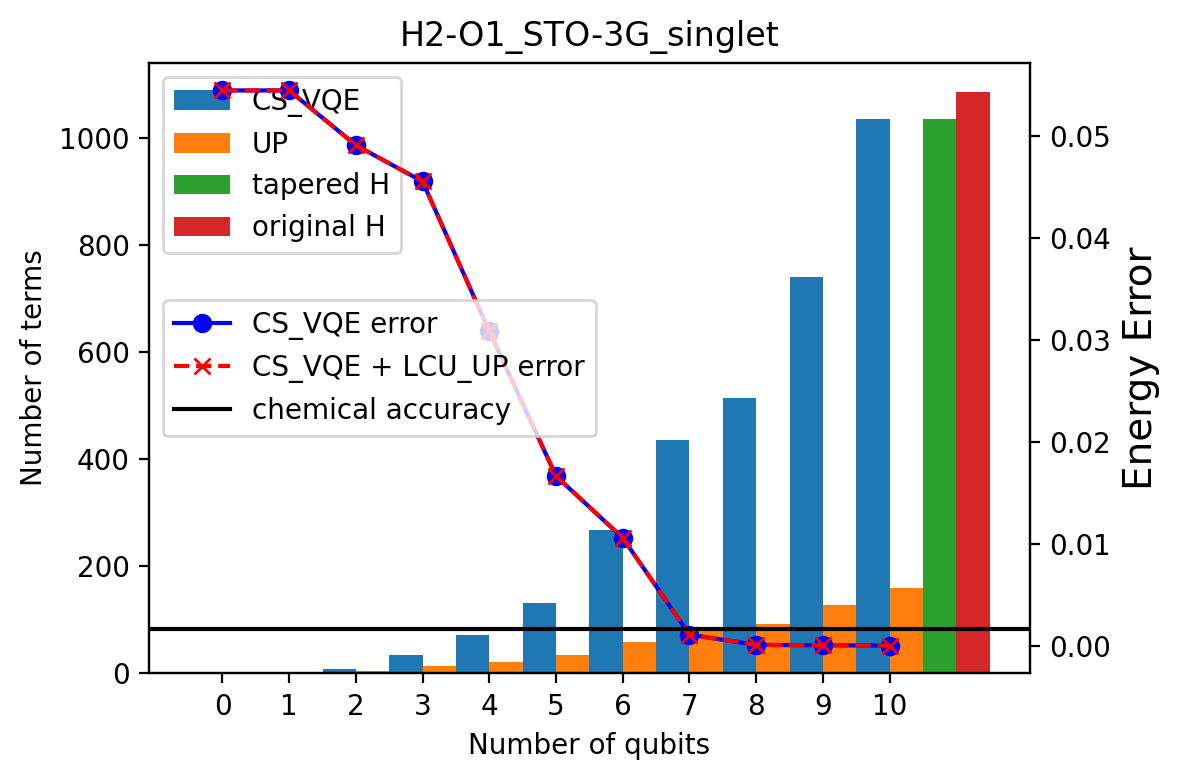

In [12]:
plot_n_terms_and_error(H2O_CS_VQE_with_and_without_UP, csvqe_results, n_terms_tapered, n_terms_full,
                           mol_key, E_LCU_dict, dpi=200)

In [13]:
n_active_qubits = 7

H_CS_VQE = H2O_CS_VQE_with_and_without_UP[n_active_qubits][0]
H_CS_VQE_and_UP = H2O_CS_VQE_with_and_without_UP[n_active_qubits][1]

# Circuits

In [14]:
## find largest anti-commuting set
## could be a problem for a real experiment!

key_larg, largest_AC_set = max(H_CS_VQE_and_UP.items(), key=lambda x:len(x[1])) # largest nonCon part found by dfs alg
largest_AC_set

[-0.01919063150326748 [Z1 Z3 Z5 X6],
 -0.009974982670680048 [Z1 Y4 Y6],
 0.16016822022287117 [Z3 Z6],
 0.0014871601146308087 [Y2 Z4 Z5 Y6],
 0.00991134660592133 [Y0 Z2 Y3 Z4 Z5],
 -0.01152557798180401 [Z0 X2 X3 Z4],
 0.01946947404842917 [Z0 X2 Y3 Y5 Z6],
 0.012755431629593271 [Z0 Y1 Y3 Z4 Z5 Z6],
 -0.00043620175985150853 [Z0 Y1 Y2 X3 Z4 Z5 Z6]]

In [15]:
from quchem.Unitary_Partitioning.Unitary_partitioning_Seq_Rot import Get_Xsk_op_list

S_index=0
check_reduction = True
N_qubits = n_active_qubits

X_sk_theta_sk_list, normalised_FULL_set, Ps, gamma_l = Get_Xsk_op_list(largest_AC_set,
                S_index,
                N_qubits,
                check_reduction=True,
                atol=1e-8,
                rtol=1e-05)

X_sk_theta_sk_list

[((-1+0j) [Z3 Y4 Z5 Z6], 3.620941883428854),
 ((1-0j) [Z1 Z5 Y6], 1.4365737102016654),
 ((-1+0j) [Z1 Y2 Z3 Z4 Z6], 0.009201216679325221),
 ((1+0j) [Y0 Z1 Z2 X3 Z4 X6], 0.06124499216453522),
 ((-1+0j) [Z0 Z1 X2 Y3 Z4 Z5 X6], -0.07105544021145027),
 ((-1+0j) [Z0 Z1 X2 X3 X5 Y6], 0.1193586928573119),
 ((-1+0j) [Z0 X1 X3 Z4 Y6], 0.07785465680270595),
 ((1-0j) [Z0 X1 Y2 Y3 Z4 Y6], -0.0026597266264886247)]

In [16]:
# from quchem.Unitary_Partitioning.Unitary_partitioning_Seq_Rot import Get_Rsl_matrix
# Rsl = Get_Rsl_matrix(X_sk_theta_sk_list, n_active_qubits)

In [ ]:
### linear algebra experiment
# Seq Rot
from quchem.Unitary_Partitioning.Unitary_partitioning_Seq_Rot import SeqRot_linalg_Energy

S_key_dict = {set_key: 0 for set_key in H_CS_VQE_and_UP}


SeqRot_linalg_Energy(H_CS_VQE_and_UP,
                     S_key_dict,
                     N_qubits,
                     atol=1e-8,
                     rtol=1e-05,
                     check_reduction=True)

In [ ]:
### linear algebra experiment
# LCU

from quchem.Unitary_Partitioning.Unitary_partitioning_LCU_method import LCU_linalg_Energy

N_indices_dict = {set_key: 0 for set_key in H_CS_VQE_and_UP}

LCU_linalg_Energy(H_CS_VQE_and_UP,
                  N_indices_dict, 
                  N_qubits, 
                  atol=1e-8, 
                  rtol=1e-05,
                  check_reduction=True)

In [18]:
from quchem.Unitary_Partitioning.Seq_Rot_circuit_functions import Build_R_SeqRot_Q_circuit

S_index=0
check_reduction_lin_alg = True
check_circuit = True

Q_circuit_Rsl, Psl, gammal = Build_R_SeqRot_Q_circuit(
                                        largest_AC_set,
                                         S_index,
                                         N_qubits,
                                         check_reduction_lin_alg=check_reduction_lin_alg,
                                        atol=1e-8,
                                        rtol=1e-05,
                                        check_circuit = check_circuit)

In [19]:
Q_circuit_Rsl

0: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(0.5π)───@────────────────────────────────────────────────@───Rx(-0.5π)───@───────────────────────────────────────────────────────────────────────@───@────────────────────────────────────────────────────────────────@──────────────@─────────────────────────────────────────────────@──────────────────@─────────────────────────────────────────────────────────────────@───────────────
                                                                                                                                                                                              │                                                │               │                                                                       │   │                                                                │              │                                                 │                  │                                                                 │
1: ───────────────────────────────────────────────────────────────@───────────────────────────────@──────────────────────@─────────────────────────────────────────@──────────────────────────X───@────────────────────────────────────────@───X───────────────X──────────@────────────────────────────────────────────────@───────────X───X──────────@─────────────────────────────────────────────────@───X───H──────────X───@─────────────────────────────────────────@───X───H───H──────────X───@─────────────────────────────────────────────────@───────────X───────────H───
                                                                  │                               │                      │                                         │                              │                                        │                              │                                                │                          │                                                 │                      │                                         │                          │                                                 │
2: ───────────────────────────────────────────────────────────────┼───────────────────────────────┼───────────Rx(0.5π)───X───@─────────────────────────────────@───X───Rx(-0.5π)──────────────────X───@────────────────────────────────@───X───────────────────H──────────X───@────────────────────────────────────────@───X───────────H───H──────────X───@─────────────────────────────────────────@───X───H──────────────────┼─────────────────────────────────────────┼───────────Rx(0.5π)───────X───@─────────────────────────────────────────@───X───────────Rx(-0.5π)───────
                                                                  │                               │                          │                                 │                                      │                                │                                      │                                        │                                  │                                         │                          │                                         │                              │                                         │
3: ──────────────@────────────────────────────────@───────────────┼───────────────────────────────┼──────────────────────────X───@─────────────────────────@───X───────────────────H──────────────────X───@────────────────────────@───X───H───────────────────Rx(0.5π)───────X───@────────────────────────────────@───X───Rx(-0.5π)───────H──────────────X───@─────────────────────────@───────────X───H───────H──────────────X───@─────────────────────────@───────────X───H───────Rx(0.5π)───────────X───@─────────────────────────@───────────X───Rx(-0.5π)───────────────────
                 │                                │               │                               │                              │  

In [61]:
len(list(Q_circuit_Rsl.all_operations()))

116

In [20]:
from quchem.Unitary_Partitioning.Unitary_partitioning_LCU_method import Get_R_op_list
from quchem.Unitary_Partitioning.LCU_circuit_functions import absorb_complex_phases

N_index=0
check_reduction = True

R_linear_comb_list, Pn, gamma_l = Get_R_op_list(largest_AC_set,
                                                N_index,
                                                N_qubits,
                                                check_reduction=check_reduction, 
                                                atol=1e-8,
                                                rtol=1e-05)


R_linear_comb_corrected_phase_OP_list, R_linear_comb_correction_values, ancilla_amplitudes, l1_norm = absorb_complex_phases(R_linear_comb_list)

In [21]:
from quchem.Unitary_Partitioning.LCU_circuit_functions import Full_LCU_Rl_Circuit
import cirq
ansatz = cirq.Circuit()

circuit = Full_LCU_Rl_Circuit(Pn,
                         R_linear_comb_corrected_phase_OP_list,
                         R_linear_comb_correction_values,
                         ancilla_amplitudes,
                         N_qubits,
                         ansatz,
                         check_G_circuit=True)

circuit

0: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────I────────────I────────────I───────Y0───────────Z0───────────Z0──────Z0──────Z0───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                            │            │            │       │            │            │       │       │
1: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────I────────────(-0-1j)*Z1───1j*Z1───(-0-1j)*Z1───(-0-1j)*Z1───1j*Z1───1j*X1───1j*X1────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────M───
                                                                                                                                                                                                                            │            │            │       │            │            │       │       │                                                                                                                                                                                                                                                                │
2: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────I────────────I────────────Y2──────Z2───────────X2───────────X2──────I───────Y2───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───
                                                                                                                                                                                                                            │            │            │       │            │            │       │       │                                                                                                                                                                                                                                                                │
3: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────(-0-1j)*Z3───I────────────Z3──────X3───────────Y3───────────X3──────X3──────Y3───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────M───
                                                                                                                                                                                                                            │            │            │       │            │            │       │       │                                                               

In [22]:
MAT = circuit.unitary()

In [37]:
from functools import reduce
N_ancilla = 4
N_system_qubits=7

I_sys = np.eye(2**N_system_qubits)

ancilla_0_state = reduce(np.kron, [np.array([[1],[0]]) for _ in range(N_ancilla)])
ancilla_0_projector = np.outer(ancilla_0_state, ancilla_0_state)

POVM_0_ancilla = np.kron(I_sys, ancilla_0_projector) # forces all zero measurement on ancilla!

In [38]:
GUG_mat = circuit.unitary()

In [39]:
projected_GUG = POVM_0_ancilla.dot(GUG_mat)

In [40]:
trace_GUG = projected_GUG.reshape([2 ** N_system_qubits, 2 ** N_ancilla,
                                                2 ** N_system_qubits, 2 ** N_ancilla])
reduced_MAT = np.einsum('jiki->jk', trace_GUG)
reduced_MAT*l1_norm

array([[ 0.98949576+0.j, -0.04982249+0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.04982249+0.j,  0.98949576+0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j, -0.04982249+0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       ...,
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.04982249+0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.98949576+0.j, -0.04982249+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.04982249+0.j,  0.98949576+0.j]])

In [46]:
from openfermion import qubit_operator_sparse
test = qubit_operator_sparse(R, n_qubits = N_system_qubits)
test.todense()

matrix([[ 0.66444934+0.j, -0.73490898+0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.73490898+0.j,  0.66444934+0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.66444934+0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        ...,
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.66444934+0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.66444934+0.j, -0.73490898+0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.73490898+0.j,  0.66444934+0.j]])

In [48]:
reduced_MAT/l1_norm

array([[ 0.34231688+0.j, -0.01723613+0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.01723613+0.j,  0.34231688+0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j, -0.01723613+0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       ...,
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.01723613+0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.34231688+0.j, -0.01723613+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.01723613+0.j,  0.34231688+0.j]])

In [23]:
from openfermion.ops import QubitOperator
Hsl = QubitOperator()

for op in largest_AC_set:
    Hsl+=op

In [24]:
R = QubitOperator()
for op in R_linear_comb_list:
    R+=op

In [25]:
from openfermion.utils import hermitian_conjugated
print(R*Hsl*hermitian_conjugated(R))
print(Pn * gamma_l)

(0.1640026722296183+0j) [Z1 Z3 Z5 X6]
0.1640026722296183 [Z1 Z3 Z5 X6]


In [28]:
R_corr = QubitOperator()
for ind, op in enumerate(R_linear_comb_corrected_phase_OP_list):
    phase = R_linear_comb_correction_values[ind]
    R_corr+=op*phase
    
print(R_corr*Hsl*hermitian_conjugated(R_corr))
print(Pn * gamma_l)

(0.1640026722296183+0j) [Z1 Z3 Z5 X6]
0.1640026722296183 [Z1 Z3 Z5 X6]


In [ ]:
R_real_amps